In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
from cv2 import imread, warpAffine

In [2]:
def get_pose_shift(pose1, pose2):
    x1, y1, angle1 = pose1
    x2, y2, angle2 = pose2
    dangle = angle1 - angle2
    dx = (x2 - x1) * np.cos(angle1) + (y2 - y1) * np.sin(angle1)
    dy = - (x2 - x1) * np.sin(angle1) + (y2 - y1) * np.cos(angle1)
    return np.array([dx, dy, dangle])

In [3]:
import numpy as np
from skimage.transform import rotate as image_rotate


def transform_pcd_xytheta(points, x, y, theta):
    points_transformed = points.copy()
    points_transformed[:, 0] = points[:, 0] * np.cos(theta) + points[:, 1] * np.sin(theta)
    points_transformed[:, 1] = -points[:, 0] * np.sin(theta) + points[:, 1] * np.cos(theta)
    points_transformed[:, 0] += x
    points_transformed[:, 1] += y
    return points_transformed

def get_occupancy_grid(points_xyz, resolution=0.1, radius=18):
    index = np.isnan(points_xyz).any(axis=1)
    points_xyz = np.delete(points_xyz, index, axis=0)
    points_xyz = np.clip(points_xyz, -8, 8)
    points_ij = np.round(points_xyz[:, :2] / resolution).astype(int) + [int(radius / resolution), int(radius / resolution)]
    grid = np.zeros((int(2 * radius / resolution), int(2 * radius / resolution)), dtype=np.uint8)
    grid[points_ij[:, 0], points_ij[:, 1]] = 1
    return grid

def normalize(angle):
    while angle < -np.pi:
        angle += 2 * np.pi
    while angle > np.pi:
        angle -= 2 * np.pi
    return angle

def rotate(x, y, angle):
    x_new = x * np.cos(angle) + y * np.sin(angle)
    y_new = -x * np.sin(angle) + y * np.cos(angle)
    return x_new, y_new

def get_rel_pose(x, y, theta, x2, y2, theta2):
    #angle = normalize(np.arctan2(y2 - y, x2 - x) - theta)
    rel_x, rel_y = rotate(x2 - x, y2 - y, theta)
    return rel_x, rel_y, theta2 - theta

def raycast(grid, n_rays=1000, center_point=None):
    grid_raycasted = grid.copy()
    if center_point is None:
        center_point = (grid.shape[0] // 2, grid.shape[1] // 2)
    for sector in range(n_rays):
        angle = sector / n_rays * 2 * np.pi - np.pi
        ii = center_point[0] + np.sin(angle) * np.arange(0, grid.shape[0] // 2)
        jj = center_point[1] + np.cos(angle) * np.arange(0, grid.shape[0] // 2)
        ii = ii.astype(int)
        jj = jj.astype(int)
        good_ids = ((ii > 0) * (ii < grid.shape[0]) ** (jj > 0) * (jj < grid.shape[1])).astype(bool)
        ii = ii[good_ids]
        jj = jj[good_ids]
        points_on_ray = grid[ii, jj]
        if len(points_on_ray.nonzero()[0]) > 0:
            last_obst = points_on_ray.nonzero()[0][-1]
            grid_raycasted[ii[:last_obst], jj[:last_obst]] = 1
        else:
            grid_raycasted[ii, jj] = 1
    return grid_raycasted

def get_iou(rel_x, rel_y, rel_theta, cur_cloud, v_cloud, cnt=0):
    if np.sqrt(rel_x ** 2 + rel_y ** 2) > 5:
        return 0
    cur_cloud_transformed = transform_pcd_xytheta(cur_cloud, rel_x, rel_y, rel_theta)
    resolution = 0.1
    cur_grid_transformed = get_occupancy_grid(cur_cloud_transformed, resolution=resolution)
    cur_grid_transformed = raycast(cur_grid_transformed, center_point=(cur_grid_transformed.shape[0] // 2 + rel_x / resolution, 
                                                                       cur_grid_transformed.shape[1] // 2 + rel_y / resolution))
    v_grid = get_occupancy_grid(v_cloud, resolution=resolution)
    v_grid = raycast(v_grid)
    intersection = np.sum(v_grid * cur_grid_transformed)
    union = np.sum(v_grid | cur_grid_transformed)
    grid_aligned = np.zeros((v_grid.shape[0], v_grid.shape[1], 3))
    grid_aligned[:, :, 0] = cur_grid_transformed
    grid_aligned[:, :, 1] = v_grid
    grid_aligned = (grid_aligned * 255).astype(np.uint8)
    #plt.figure(figsize=(12, 12))
    #plt.imshow(grid_aligned)
    #plt.scatter(cur_cloud_transformed[::7, 0], cur_cloud_transformed[::7, 1], s=5, alpha=0.1)
    #plt.scatter(v_cloud[::7, 0], v_cloud[::7, 1], s=5, alpha=0.1)
    #plt.show()
    return intersection / union

In [4]:
"""Pointcloud registration pipeline."""
from os import PathLike
from typing import List, Optional, Tuple, Union

import numpy as np
import open3d as o3d
import torch
import cv2
from torch import Tensor, nn

import sys
sys.path.append('/home/kirill/TopoSLAM/OpenPlaceRecognition/src')
from opr.utils import init_model, parse_device


detector = cv2.ORB_create()
outlier_threshold = 50
min_matches = 5

def point_based_matching(point_pairs):
    """
    This function is based on the paper "Robot Pose Estimation in Unknown Environments by Matching 2D Range Scans"
    by F. Lu and E. Milios.

    :param point_pairs: the matched point pairs [((x1, y1), (x1', y1')), ..., ((xi, yi), (xi', yi')), ...]
    :return: the rotation angle and the 2D translation (x, y) to be applied for matching the given pairs of points
    """
    x_mean = 0
    y_mean = 0
    xp_mean = 0
    yp_mean = 0
    n = len(point_pairs)
    if n == 0:
        return None, None, None
    for pair in point_pairs:
        (x, y), (xp, yp) = pair
        x_mean += x
        y_mean += y
        xp_mean += xp
        yp_mean += yp
    x_mean /= n
    y_mean /= n
    xp_mean /= n
    yp_mean /= n
    s_x_xp = 0
    s_y_yp = 0
    s_x_yp = 0
    s_y_xp = 0
    for pair in point_pairs:
        (x, y), (xp, yp) = pair
        s_x_xp += (x - x_mean)*(xp - xp_mean)
        s_y_yp += (y - y_mean)*(yp - yp_mean)
        s_x_yp += (x - x_mean)*(yp - yp_mean)
        s_y_xp += (y - y_mean)*(xp - xp_mean)
    rot_angle = np.arctan2(s_x_yp - s_y_xp, s_x_xp + s_y_yp)
    translation_x = xp_mean - (x_mean*np.cos(rot_angle) - y_mean*np.sin(rot_angle))
    translation_y = yp_mean - (x_mean*np.sin(rot_angle) + y_mean*np.cos(rot_angle))
    return rot_angle, translation_x, translation_y

def remove_floor_and_ceil(cloud: np.ndarray) -> np.ndarray:
    floor_height = -0.9
    ceil_height = 1.5
    return cloud[(cloud[:, 2] > floor_height) * (cloud[:, 2] < ceil_height)]

def extract_floor(cloud: np.ndarray) -> np.ndarray:
    heights = np.linspace(-4.0, 4.0, 41)
    bins = []
    for i, height in enumerate(heights[:-1]):
        bins.append(len(cloud[(cloud[:, 2] > height) * (cloud[:, 2] < heights[i + 1])]))
    #print('Bins:', bins)
    floor_index = np.argmax(bins[:20]) + 1
    floor_height = heights[floor_index]
    assert floor_index < len(heights) - 5
    return cloud[cloud[:, 2] <= floor_height]

def pcd_to_img(cloud: np.ndarray, grid_size: float = 0.05) -> np.ndarray:
    points = cloud[(np.abs(cloud[:, 0]) < 15) * (np.abs(cloud[:, 1]) < 15)]
    grid = np.zeros((int(32 / grid_size) + 1, int(32 / grid_size) + 1))
    points_int = ((points + [16, 16]) / grid_size).astype(np.int32)
    grid[points_int[:, 0], points_int[:, 1]] = 1
    return grid

def transform_pcd(points: np.ndarray, tf_matrix: np.ndarray) -> np.ndarray:
    points_expanded = np.concatenate([points[:, :3], np.ones((points.shape[0], 1))], axis=1)
    points_transformed = np.linalg.inv(tf_matrix) @ points_expanded.T
    points_transformed = points_transformed.T[:, :3] / points_transformed.T[:, 3:]
    return points_transformed

def get_fitness(cand_cloud, ref_cloud, tf_matrix):
    grid_size = 0.05
    ref_cloud_wo_floor_and_ceil = remove_floor_and_ceil(ref_cloud)[:, :2]
    ref_cloud_floor = extract_floor(ref_cloud)[:, :2]
    cand_cloud_transformed = transform_pcd(cand_cloud, np.linalg.inv(tf_matrix))
    cand_cloud_wo_floor_and_ceil = remove_floor_and_ceil(cand_cloud_transformed)[:, :2]
    cand_cloud_floor = extract_floor(cand_cloud_transformed)[:, :2]
    kernel = np.ones((7, 7), dtype=np.uint8)
    ref_wall_mask = pcd_to_img(ref_cloud_wo_floor_and_ceil)
    ref_wall_mask_dilated = cv2.dilate(ref_wall_mask, kernel)
    cand_wall_mask = pcd_to_img(cand_cloud_wo_floor_and_ceil)
    cand_wall_mask_dilated = cv2.dilate(cand_wall_mask, kernel)
    ref_floor_mask = pcd_to_img(ref_cloud_floor)
    ref_floor_mask = raycast(ref_wall_mask) - ref_wall_mask
    cand_floor_mask = pcd_to_img(cand_cloud_floor)
    center_point = (cand_floor_mask.shape[0] // 2 + tf_matrix[0, 3] / grid_size, \
                    cand_floor_mask.shape[0] // 2 + tf_matrix[1, 3] / grid_size)
    cand_floor_mask = raycast(cand_wall_mask, center_point=center_point) - cand_wall_mask
    intersection = np.sum(np.clip(ref_wall_mask + ref_floor_mask, 0, 1) * np.clip(cand_wall_mask + cand_floor_mask, 0, 1))
    union = np.sum(np.clip(ref_wall_mask + ref_floor_mask + cand_wall_mask + cand_floor_mask, 0, 1))
    plt.figure(figsize=(12, 12))
    grid_aligned = np.zeros((ref_wall_mask.shape[0], ref_wall_mask.shape[1], 3))
    grid_aligned[:, :, 0] = ref_floor_mask
    grid_aligned[:, :, 1] = cand_floor_mask
    plt.imshow(grid_aligned)
    plt.hlines(320, 200, 440)
    plt.vlines(320, 200, 440)
    print('Center point:', center_point)
    plt.scatter([center_point[1]], [center_point[0]], s=50, color='r')
    plt.scatter([cand_floor_mask.shape[0] // 2], [cand_floor_mask.shape[1] // 2], s=50, color='b')
    plt.show()
    iou = intersection / union
    good_match = np.sum(cand_wall_mask_dilated * ref_wall_mask)
    bad_match = np.sum(cand_floor_mask * (1 - cand_wall_mask_dilated) * ref_wall_mask) + \
                np.sum(ref_floor_mask * (1 - ref_wall_mask_dilated) * cand_wall_mask)
    #save_dir = os.path.join(self.save_dir, str(self.cnt))
    return iou, good_match / (good_match + bad_match) * iou ** 0.25

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:
from tqdm import tqdm_notebook
from skimage.io import imread

In [16]:
from mpl_toolkits.mplot3d import Axes3D

In [306]:
graph_dir = '/home/kirill/TopoSLAM/toposlam_ws/src/simple_toposlam_model/test_husky_rosbag_minkloc3d_5/graph_data'
pr_results_dir = '/home/kirill/TopoSLAM/toposlam_ws/src/simple_toposlam_model/test_husky_rosbag_minkloc3d_5/place_recognition_data'
stamps = [int(x) for x in os.listdir(pr_results_dir)]
stamps.sort()

In [307]:
stamps

[1717296282436903000,
 1717296363092656000,
 1717296368819717000,
 1717296371738771000,
 1717296374603321000,
 1717296377594506000,
 1717296380807782000,
 1717296383590767000,
 1717296386692234000,
 1717296389543009000,
 1717296392657712000,
 1717296395841150000,
 1717296398602113000,
 1717296401680056000,
 1717296404344096000,
 1717296407287428000,
 1717296410541833000,
 1717296413482368000,
 1717296416474525000,
 1717296419490767000,
 1717296422688113000,
 1717296425449619000,
 1717296428330541000,
 1717296431473564000,
 1717296434653464000,
 1717296437548783000,
 1717296440654048000,
 1717296443941839000,
 1717296446625374000,
 1717296449804627000,
 1717296452817067000,
 1717296455759488000,
 1717296458710125000,
 1717296461416105000,
 1717296464604991000,
 1717296467675921000,
 1717296470643515000,
 1717296473697906000,
 1717296476749825000,
 1717296479452854000,
 1717296482438529000,
 1717296485468347000,
 1717296488398099000,
 1717296491483509000,
 1717296494584827000,
 171729649

In [308]:
#for stamp, vertex_id in zip(failed_stamps, failed_cands):
for stamp in [1716275797354849000]:
    pr_dir = os.path.join(pr_results_dir, str(stamp))
    vertex_ids = np.loadtxt(os.path.join(pr_dir, 'vertex_ids.txt'))
    vertex_ids = [int(i) for i in vertex_ids if i >= 0]
    for vertex_id in vertex_ids:
        print('Stamp {}, cand {}'.format(stamp, vertex_id))
        pr_scores = np.loadtxt(os.path.join(pr_dir, 'pr_scores.txt'))
        reg_scores = np.loadtxt(os.path.join(pr_dir, 'reg_scores.txt'))
        reg_scores = reg_scores.reshape((reg_scores.size,))
        ref_cloud = np.load(os.path.join(pr_dir, 'cloud.npz'))['arr_0']
        ref_cloud = remove_floor_and_ceil(ref_cloud)
        #ref_cloud = rotate_vertical(ref_cloud, 0.039)
        ref_image_front = imread(os.path.join(pr_dir, 'img_front.png'))
        ref_image_back = imread(os.path.join(pr_dir, 'img_back.png'))
        gt_poses = np.loadtxt(os.path.join(pr_dir, 'gt_poses.txt'))
        transforms_ = np.loadtxt(os.path.join(pr_dir, 'transforms.txt'))
        transforms_ = transforms_.reshape((transforms_.size // 7, 7))
        i = list(transforms_[:, 0]).index(vertex_id)
        #print(transforms_)
        vertex_ids = [int(x) for x in transforms_[:, 0]]
        save_path = 'test_registration'
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        #print('Reg scores:', reg_scores)
        #for i, vertex_id in enumerate(vertex_ids):
        cloud = np.load(os.path.join(graph_dir, str(vertex_id), 'cloud.npz'))['arr_0']
        cloud = remove_floor_and_ceil(cloud)
        print(stamp, vertex_id)
        print('Reference pose:', gt_poses[0])
        print('Candidate pose:', gt_poses[i + 1])
        #gt_dist = np.sqrt(np.sum((gt_poses[0] - gt_poses[i + 1]) ** 2))
        #print('Gt dist:', gt_dist)
        #if gt_dist < 10 or reg_scores[i] < 0.5:
        #    continue
        save_dir = os.path.join(save_path, '{}_{}'.format(stamp, vertex_id))
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        #fout = open(os.path.join(save_dir, 'output.txt'), 'w')
        #cloud = rotate_vertical(cloud, 0.039)
        image_front = imread(os.path.join(graph_dir, str(vertex_id), 'img_front.png'))
        image_back = imread(os.path.join(graph_dir, str(vertex_id), 'img_back.png'))
        """
        plt.figure(figsize=(18, 14))
        plt.subplot(2, 2, 1)
        plt.title('Ref image front', fontsize=20)
        plt.imshow(ref_image_front)
        plt.subplot(2, 2, 2)
        plt.title('Cand image front', fontsize=20)
        plt.imshow(image_front)
        plt.subplot(2, 2, 3)
        plt.title('Ref image back', fontsize=20)
        plt.imshow(ref_image_back)
        plt.subplot(2, 2, 4)
        plt.title('Cand image back', fontsize=20)
        plt.imshow(image_back)
        """
        ref_cloud_numpy_cropped = remove_floor_and_ceil(ref_cloud)[:, :2]
        #print('Ref cloud cropped shape:', ref_cloud_numpy_cropped.shape)
        img_ref = pcd_to_img(ref_cloud_numpy_cropped)
        img_ref = (img_ref * 255).astype(np.uint8)
        kernel = np.ones((3, 3))
        img_ref = cv2.dilate(img_ref, kernel)
        img_ref = cv2.GaussianBlur(img_ref, (3, 3), 1)
        #img_ref = cv2.resize(img_ref, None, fx=0.5, fy=0.5)
        #print('Img ref min and max:', img_ref.min(), img_ref.mean(), img_ref.max())
        cand_cloud_numpy_cropped = remove_floor_and_ceil(cloud)[:, :2]
        #print('Cand cloud numpy cropped shape:', cand_cloud_numpy_cropped.shape)
        img_cand = pcd_to_img(cand_cloud_numpy_cropped)
        img_cand = (img_cand * 255).astype(np.uint8)
        img_cand = cv2.dilate(img_cand, kernel)
        img_cand = cv2.GaussianBlur(img_cand, (3, 3), 1)
        #img_cand = cv2.resize(img_cand, None, fx=0.5, fy=0.5)
        #print('Img cand min and max:', img_cand.min(), img_cand.mean(), img_cand.max())
        # Extract features
        kp_ref, des_ref = detector.detectAndCompute(img_ref, None)
        kp_cand, des_cand = detector.detectAndCompute(img_cand, None)
        #print(kp_ref, des_ref)
        #print(kp_cand, des_cand)

        # Match features using KNN
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm = FLANN_INDEX_LSH,
                        table_number = 6, # 12
                        key_size = 12,     # 20
                        multi_probe_level = 1) #2
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(des_ref, des_cand, k=2)
        matches = [x for x in matches if len(x) == 2]
        print('Found {} matches'.format(len(matches)))
        """
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img_ref)
        plt.subplot(1, 2, 2)
        plt.imshow(img_cand)
        plt.show()
        """
        # Need to draw only good matches, so create a mask
        matchesMask = [[0,0] for i in range(len(matches))]
        # ratio test as per Lowe's paper
        good = []
        good_ids = []
        for iii,(m,n) in enumerate(matches):
            if m.distance < 0.8*n.distance:
                good.append(m)
                matchesMask[iii]=[1,0]
                good_ids.append(iii)
        good_ids = np.array(good_ids)
        print('{} of them are good'.format(len(good)))
        draw_params = dict(#matchColor = (0,255,0),
                           singlePointColor = (255,0,0),
                           matchesMask = matchesMask[::max(1, len(good_ids) // 10)],
                           flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        img_matches = np.zeros((400, 400, 3))
        img_matches = cv2.drawMatchesKnn(img_ref,kp_ref,img_cand,kp_cand,
                                      matches[::max(1, len(good_ids) // 10)], img_matches, **draw_params)
        #plt.figure(figsize=(18, 10))
        #plt.imshow(255 - img_matches)
        #plt.savefig(os.path.join(save_dir, 'matching.png'))
        #plt.show()

        # Remove outliers
        src_pts = np.float32([ kp_ref[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_cand[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        outlier_thresholds = [50, 20, 10, 5, 5]
        #outlier_thresholds = np.array(outlier_thresholds) * 0.5
        for iteration in range(5):
            if len(src_pts) < min_matches:
                print('Unable to find transform: too few matches!')
                break
            point_pairs = np.concatenate([src_pts, dst_pts], axis=1)
            rot_angle, trans_j, trans_i = point_based_matching(point_pairs)
            print(trans_i, trans_j, rot_angle)
            src_transformed = src_pts[:, 0, :].copy()
            src_transformed[:, 0] = src_pts[:, 0, 0] * np.cos(-rot_angle) + src_pts[:, 0, 1] * np.sin(-rot_angle) + trans_j
            src_transformed[:, 1] = -src_pts[:, 0, 0] * np.sin(-rot_angle) + src_pts[:, 0, 1] * np.cos(-rot_angle) + trans_i
            matching_error = np.sqrt((src_transformed[:, 0] - dst_pts[:, 0, 0]) ** 2 + (src_transformed[:, 1] - dst_pts[:, 0, 1]) ** 2)
            print(matching_error)
            outlier_threshold = outlier_thresholds[iteration]
            print('Number of outliers:', (matching_error > outlier_threshold).sum())
            if matching_error.max() < outlier_thresholds[-1]:
                break
            src_pts = src_pts[matching_error < outlier_threshold]
            dst_pts = dst_pts[matching_error < outlier_threshold]
            good_ids = good_ids[matching_error < outlier_threshold]
            matchesMask = [[0,0] for i in range(len(matches))]
            for iii in good_ids:
                matchesMask[iii] = [1, 0]
            draw_params = dict(#matchColor = (0,255,0),
            singlePointColor = (255,0,0),
            matchesMask = matchesMask[::max(1, len(good_ids) // 10)],
            flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            
            img_matches = np.zeros((400, 400, 3))
            img_matches = cv2.drawMatchesKnn(img_ref,kp_ref,img_cand,kp_cand,
                                      matches[::max(1, len(good_ids) // 10)], img_matches, **draw_params)
            #plt.figure(figsize=(18, 10))
            #plt.imshow(255 - img_matches)
            #plt.savefig(os.path.join(save_dir, 'matching.png'))
            #plt.show()
        if len(src_pts) >= min_matches:
            point_pairs = np.concatenate([src_pts, dst_pts], axis=1)
            rot_angle, trans_j, trans_i = point_based_matching(point_pairs)
            print(trans_i, trans_j, rot_angle)
            resolution = 0.05
            tf_matrix = np.array([
                [np.cos(rot_angle), np.sin(rot_angle), 0, trans_i * resolution],
                [-np.sin(rot_angle), np.cos(rot_angle), 0, trans_j * resolution],
                [0,                  0,                 1, 0],
                [0,                  0,                 0, 1]
            ])
            max_range = 16
            plus8 = np.eye(4)
            plus8[0, 3] = max_range
            plus8[1, 3] = max_range
            minus8 = np.eye(4)
            minus8[0, 3] = -max_range
            minus8[1, 3] = -max_range
            tf_matrix = minus8 @ tf_matrix @ plus8
            plt.figure(figsize=(8, 8))
            rel_x, rel_y, rel_theta = get_pose_shift(gt_poses[0], gt_poses[i + 1])
            print('True rel x y theta:', rel_x, rel_y, rel_theta)
            #rel_x, rel_y, rel_theta = transforms_[i, 4], transforms_[i, 5], transforms_[i, 3]
            rel_x, rel_y, rel_theta = tf_matrix[0, 3], tf_matrix[1, 3], rot_angle
            print('Rel x y theta:', rel_x, rel_y, rel_theta)
            rel_x, rel_y, rel_theta = resolution * trans_i + max_range * (np.cos(rot_angle) + np.sin(rot_angle) - 1), \
                                      resolution * trans_j + max_range * (np.cos(rot_angle) - np.sin(rot_angle) - 1), \
                                      rot_angle
            print('Rel x y theta 2:', rel_x, rel_y, rel_theta)
            rel_x_rotated = rel_x * np.cos(-rel_theta) + rel_y * np.sin(-rel_theta)
            rel_y_rotated = -rel_x * np.sin(-rel_theta) + rel_y * np.cos(-rel_theta)
            print('Rel x y theta rotated:', rel_x_rotated, rel_y_rotated, rel_theta)
            ref_cloud_transformed = transform_pcd_xytheta(ref_cloud, rel_x, rel_y, rel_theta)
            iou = get_iou(rel_x, rel_y, rel_theta, ref_cloud, cloud)
            plt.title('Stamp: {}, cand {}, IoU: {}, reg_score: {}'.format(stamp, vertex_id, round(iou, 2), round(reg_scores[i], 2)), fontsize=20)
            plt.xlim((-8, 8))
            plt.ylim((-8, 8))
            plt.scatter(cloud[::7, 0], cloud[::7, 1], s=5, alpha=0.1)
            plt.scatter(ref_cloud_transformed[::7, 0], ref_cloud_transformed[::7, 1], s=5, alpha=0.1)
            plt.scatter([rel_x], [rel_y], s=50, color='r')
            plt.scatter([0], [0], s=50, color='b')
            #plt.savefig(os.path.join(save_dir, 'alignment.png'))
            plt.show()
            #fout.close()
            reg_score = get_fitness(ref_cloud, cloud, tf_matrix)
            print('Reg score:', reg_score)

FileNotFoundError: /home/kirill/TopoSLAM/toposlam_ws/src/simple_toposlam_model/test_husky_rosbag_minkloc3d_5/place_recognition_data/1716275797354849000/vertex_ids.txt not found.

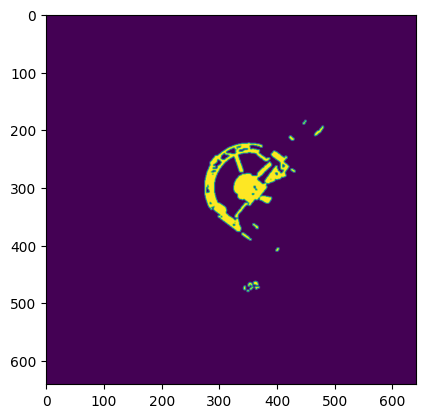

In [23]:
plt.imshow(img_ref)

In [55]:
angle = -0.1
tf_matrix = np.array([
    [np.cos(angle), np.sin(angle), 0],
    [-np.sin(angle), np.cos(angle), -0]
])
img_ref_warped = warpAffine(img_ref, tf_matrix, img_ref.shape)
print(img_ref_warped.max())

255


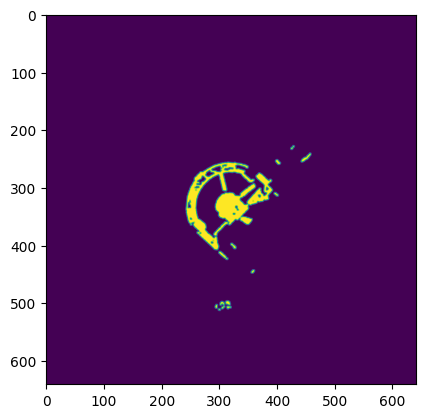

In [56]:
plt.imshow(img_ref_warped)

In [ ]:
kp_ref[1].pt

In [ ]:
ref_coords_transformed = np.zeros((len(img_ref.nonzero()[0]), 2))
ref_coords_transformed[:, 0] = img_ref.nonzero()[0] * np.cos(rot_angle) + img_ref.nonzero()[1] * np.sin(rot_angle) + trans_i
ref_coords_transformed[:, 1] = -img_ref.nonzero()[0] * np.sin(rot_angle) + img_ref.nonzero()[1] * np.cos(rot_angle) + trans_j
ref_coords_transformed = ref_coords_transformed.astype(int)
ref_coords_transformed = ref_coords_transformed[(ref_coords_transformed[:, 0] >= 0) * (ref_coords_transformed[:, 0] < img_cand.shape[0]) *\
                                                (ref_coords_transformed[:, 1] >= 0) * (ref_coords_transformed[:, 1] < img_cand.shape[1])]

In [ ]:
img_ref_transformed = np.zeros_like(img_cand).astype(np.uint8)
img_ref_transformed[ref_coords_transformed[:, 0], ref_coords_transformed[:, 1]] = 255

In [ ]:
160 * np.cos(-0.33) + 160 * np.sin(-0.33) + 60

In [ ]:
-160 * np.sin(-0.33) + 160 * np.cos(-0.33) - 33

In [ ]:
plt.imshow(img_ref)
plt.scatter([582], [550], s=20, color='r')

In [ ]:
plt.imshow(img_ref_transformed + img_cand)
plt.scatter([160], [160], color='r', s=50)

In [ ]:
save_dir = '/home/kirill/TopoSLAM/OpenPlaceRecognition/test_registration/3'
grid_aligned = imread(os.path.join(save_dir, 'grid_aligned.png'))
grid_aligned[grid_aligned > 0] = 1
intersection = np.sum((grid_aligned[:, :, 0] > 0) * (grid_aligned[:, :, 1] > 0))
union = np.sum((grid_aligned[:, :, 0] + grid_aligned[:, :, 1] > 0))
print('Intersection:', intersection)
print('Union:', union)
print('IoU:', intersection / union)

In [ ]:
plt.imshow(grid_aligned * 255)

In [ ]:
ref_cloud = np.load(os.path.join(save_dir, 'ref_cloud.npz'))['arr_0']
cand_cloud = np.load(os.path.join(save_dir, 'cand_cloud.npz'))['arr_0']
cand_cloud_transformed = np.load(os.path.join(save_dir, 'cand_cloud_transformed.npz'))['arr_0']
tf_matrix = np.loadtxt(os.path.join(save_dir, 'tf_matrix.txt'))

In [ ]:
plt.scatter(ref_cloud[::7, 0], ref_cloud[::7, 1], s=5, alpha=0.1)
#cand_cloud_transformed = transform_pcd(cand_cloud, tf_matrix)
plt.scatter(cand_cloud_transformed[::7, 0], cand_cloud_transformed[::7, 1], s=5, alpha=0.1)

In [ ]:
grid = np.zeros((321, 321))
center_point = [250, 250]
angle = 0
ii = center_point[0] + np.sin(angle) * np.arange(0, grid.shape[0] // 2)
jj = center_point[1] + np.cos(angle) * np.arange(0, grid.shape[0] // 2)
ii = ii.astype(int)
jj = jj.astype(int)
good_ids = ((ii > 0) * (ii < grid.shape[0]) ** (jj > 0) * (jj < grid.shape[1])).astype(bool)
print('Len ii before:', len(ii))
ii = ii[good_ids]
jj = jj[good_ids]
print('Len ii after:', len(ii))
print(ii.min(), ii.max(), jj.min(), jj.max(), grid.shape)

## Test IoU

In [296]:
save_dir = '/home/kirill/test_iou'
cnt = 170
cur_cloud = np.load(os.path.join(save_dir, str(cnt), 'cur_cloud.npz'))['arr_0']
cur_cloud_transformed = np.load(os.path.join(save_dir, str(cnt), 'cur_cloud_transformed.npz'))['arr_0']
v_cloud = np.load(os.path.join(save_dir, str(cnt), 'v_cloud.npz'))['arr_0']
cur_cloud = remove_floor_and_ceil(cur_cloud)
cur_cloud_transformed = remove_floor_and_ceil(cur_cloud_transformed)
v_cloud = remove_floor_and_ceil(v_cloud)
grid_aligned = imread(os.path.join(save_dir, str(cnt), 'grid_aligned.png'))
rel_pose = np.loadtxt(os.path.join(save_dir, str(cnt), 'rel_pose.txt'))

In [297]:
cur_grid = get_occupancy_grid(cur_cloud)
cur_grid_from_transformed_cloud = get_occupancy_grid(cur_cloud_transformed)
v_grid = get_occupancy_grid(v_cloud)

In [298]:
rel_x, rel_y, rel_theta = rel_pose
resolution = 0.1
minus8 = np.array([
    [1, 0, 18 / resolution],
    [0, 1, 18 / resolution],
    [0, 0, 1]
])
plus8 = np.array([
    [1, 0, -18 / resolution],
    [0, 1, -18 / resolution],
    [0, 0, 1]
])
tf_matrix = np.array([
    [np.cos(-rel_theta), np.sin(-rel_theta), rel_y / resolution],
    [-np.sin(-rel_theta), np.cos(-rel_theta), rel_x / resolution],
    [0, 0, 1]
])
tf_matrix = minus8 @ tf_matrix @ plus8
cur_grid_transformed = warpAffine(cur_grid, tf_matrix[:2], cur_grid.shape)

In [304]:
tf_matrix

array([[-3.35714899e-01, -9.41963644e-01,  4.09153412e+02],
       [ 9.41963644e-01, -3.35714899e-01,  7.33377529e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [299]:
print(rel_x, rel_y)

0.24625269522190102 -0.08287253283974298


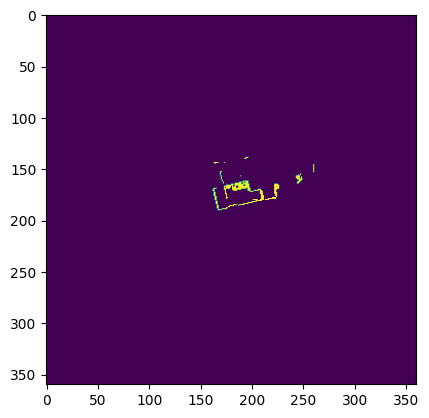

In [300]:
plt.imshow(cur_grid_from_transformed_cloud)

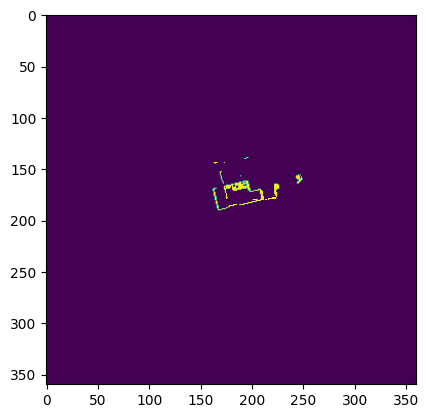

In [301]:
plt.imshow(cur_grid_transformed * cur_grid_from_transformed_cloud)

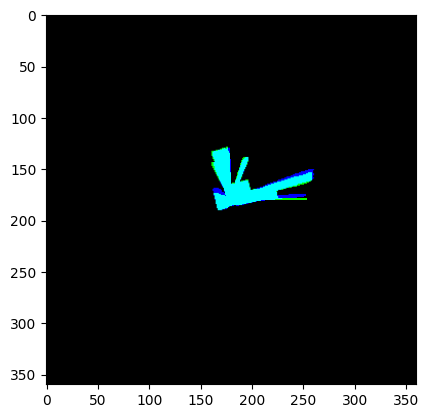

In [302]:
plt.imshow(grid_aligned)

In [255]:
grid_aligned[grid_aligned > 0] = 1
intersection = (grid_aligned[:, :, 0] * grid_aligned[:, :, 1]).sum()
union = (grid_aligned[:, :, 0] | grid_aligned[:, :, 1]).sum()
print('IoU:', intersection / union)

IoU: 0.0


In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(v_cloud[:, 0], v_cloud[:, 2], s=5, alpha=0.1)